# Face Mask Detection Computer Vision

<img src="https://allai.nl/wp-content/uploads/2021/02/Screenshot-2021-02-11-at-16.52.15-495x400.png">

## 🎯 Project Objective

The goal of this project is to build a **binary image classification model** that predicts whether a face mask is present in an image or not.  
Although the original dataset is designed for **object detection**, it is reformulated as an **image-level classification task** to simplify the pipeline and focus on training and deployment.


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as et
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import warnings

warnings.filterwarnings("ignore")

## 📊 Dataset Description

- Dataset: Face Mask Detection
- Image format: RGB images
- Annotation format: Pascal VOC (XML)
- Reformulated task: Binary image classification

### Label Mapping
- `1` → Mask present
- `0` → No mask present

Each image receives a single label based on its annotations.

In [2]:
annotations = "/kaggle/input/face-mask-detection/annotations"
images = "/kaggle/input/face-mask-detection/images"

In [3]:
xml_files = glob.glob(f"{annotations}/*.xml")

In [4]:
rows = []

for file in xml_files:
    root = et.parse(file).getroot()
    filename = root.find("filename").text
    img = f"{images}/{filename}"

    labels = [obj.find("name").text.lower() for obj in root.findall("object")]
    label = 1 if "with_mask" in labels else 0

    rows.append([img, label])

In [5]:
df = pd.DataFrame(rows, columns=["img", "label"])

In [6]:
df.head()

,img,label
0,/kaggle/input/face-mask-detection/images/makss...,1
1,/kaggle/input/face-mask-detection/images/makss...,1
2,/kaggle/input/face-mask-detection/images/makss...,0
3,/kaggle/input/face-mask-detection/images/makss...,1
4,/kaggle/input/face-mask-detection/images/makss...,1


In [7]:
df.tail()

,img,label
848,/kaggle/input/face-mask-detection/images/makss...,1
849,/kaggle/input/face-mask-detection/images/makss...,1
850,/kaggle/input/face-mask-detection/images/makss...,1
851,/kaggle/input/face-mask-detection/images/makss...,1
852,/kaggle/input/face-mask-detection/images/makss...,1


In [8]:
df.shape

(853, 2)

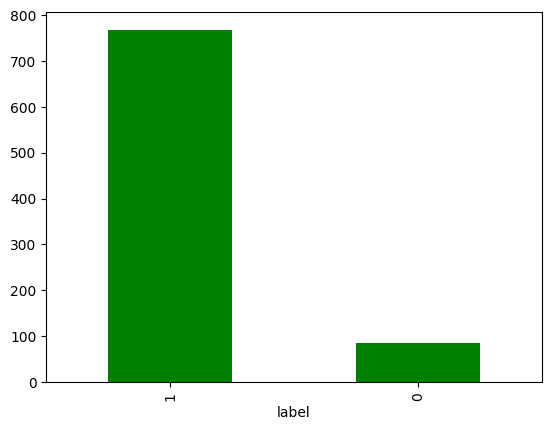

In [9]:
df["label"].value_counts().plot(kind="bar", color="green")
plt.show()

## 🧹 Data Preprocessing

The preprocessing pipeline includes:
- Parsing XML annotations to generate image-level labels
- Resizing images to `224 × 224`
- Converting images to tensors
- Splitting the dataset into training and validation sets using stratified sampling

In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1])

weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=df["label"].values)

class_weights = {0: weights[0], 1: weights[1]}
class_weights

{0: np.float64(5.017647058823529), 1: np.float64(0.5553385416666666)}

In [11]:
train_df, val_df = train_test_split(df,test_size=0.2,stratify=df["label"],random_state=42)

In [12]:
train_df = train_df.reset_index(drop=True)

In [13]:
val_df = val_df.reset_index(drop=True)

In [14]:
counts = train_df["label"].value_counts().sort_index()
class_weights = counts.sum() / (2.0 * counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float)


## 🤖 Model Training

A **ResNet18** model pre-trained on ImageNet is used as the backbone.  
The final fully connected layer is modified to output two classes.

Training configuration:
- Loss function: CrossEntropyLoss with class weights
- Optimizer: Adam
- Metrics: Accuracy and F1-score

In [15]:
img_size = 224
batch_size = 32

train_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),])

In [16]:
def load_images(df, tfms):
    xs = []
    ys = []

    for i in range(len(df)):
        img_path = df.loc[i, "img"]
        y = int(df.loc[i, "label"])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = tfms(img)

        xs.append(img)
        ys.append(y)

    x = torch.stack(xs)
    y = torch.tensor(ys, dtype=torch.long)

    return x, y

In [17]:
x_train, y_train = load_images(train_df, train_tfms)
x_val, y_val = load_images(val_df, val_tfms)

train_ds = torch.utils.data.TensorDataset(x_train, y_train)
val_ds = torch.utils.data.TensorDataset(x_val, y_val)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s] 


In [19]:
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for x, y in train_dl:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    preds = []
    gts = []

    with torch.no_grad():
        for x, y in val_dl:
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            p = torch.argmax(out, dim=1)

            preds.extend(p.cpu().numpy().tolist())
            gts.extend(y.cpu().numpy().tolist())

    acc = accuracy_score(gts, preds)
    f1 = f1_score(gts, preds)

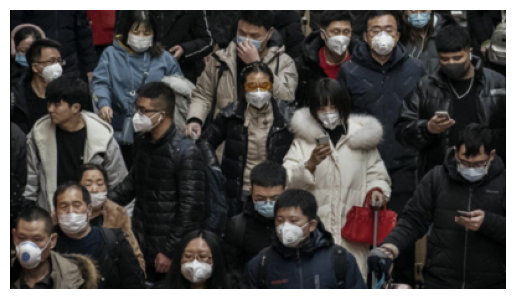

In [20]:
idx = np.random.randint(0, len(val_df))
img_path = val_df.loc[idx, "img"]
true_label = int(val_df.loc[idx, "label"])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

x = val_tfms(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    out = model(x)
    pred = int(torch.argmax(out, dim=1).item())

plt.imshow(img)
plt.axis("off")
plt.show()

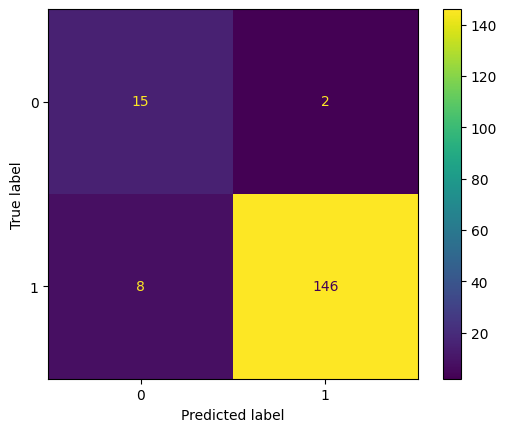

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(gts, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


## 🏆 Results Comparison

Model performance is evaluated on the validation set.  
Due to class imbalance, **F1-score** is considered the primary evaluation metric.

The confusion matrix shows that the model performs strongly on detecting masked faces while maintaining reasonable performance on the minority class.

In [22]:
model_path = "mask_cls_resnet18.pth"

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "img_size": img_size,
        "labels": {0: "no_mask", 1: "with_mask"},
    },
    model_path)